| Etapa                      | Tecnologia recomendada                              | Justificativa                                           |
| -------------------------- | --------------------------------------------------- | ------------------------------------------------------- |
| Orquestração mensal        | `cron` no App Service ou Azure Functions            | Automação simples                                       |
| Ambiente isolado           | Docker                                              | Facilita dependências (`duckdb`, `pandas`, `azure-sdk`) |
| Extração + Upload Bronze   | Python puro (`requests`, `zipfile`, `DataLake SDK`) | Você já faz isso bem                                    |
| Transformações Silver/Gold | `Pandas` ou `DuckDB`                                | Leves, simples, ideais para CSV                         |
| Deploy                     | Azure App Service + GitHub Actions                  | CI/CD automatizado                                      |


cnes-data-pipeline/
│
├── Dockerfile
├── requirements.txt
├── app.py                  ← ponto de entrada principal
├── extract/
│   └── extract_cnes.py     ← download e bronze upload
├── transform/
│   ├── silver.py           ← limpeza e joins
│   └── gold.py             ← agregações e finais
├── utils/
│   └── azure_datalake.py   ← funções para leitura/escrita
└── cron/
    └── crontab.txt         ← para rodar mensalmente no container


# Conexão com o Datalake

In [1]:
from azure.storage.filedatalake import DataLakeServiceClient
from io import BytesIO
import os
import pandas as pd

# =========================
# Conexão
# =========================
ACCOUNT_NAME = "cnesstorage"
ACCOUNT_KEY  = os.getenv("AZURE_STORAGE_KEY", "/ae47eZuE0NGPopxVHEkxOKsQwtEm3qQM0vBRPBRbB5nAW1zO6FPkEO9gwNQwkqExaVhOyHWgb68+AStIau+Uw==")
FILE_SYSTEM  = "gold"

service_client = DataLakeServiceClient(
    account_url=f"https://{ACCOUNT_NAME}.dfs.core.windows.net",
    credential=ACCOUNT_KEY,
)
fs = service_client.get_file_system_client(FILE_SYSTEM)


def read_from_adls(
    fs_client,
    path: str,
    file_type: str | None = None,
    **kwargs
) -> pd.DataFrame:
    """
    Lê um arquivo do ADLS em memória e carrega em um DataFrame Pandas.

    Params:
      fs_client : FileSystemClient do ADLS
      path      : caminho no container (ex: 'estabelecimentos_202501.parquet')
      file_type : 'parquet' | 'csv' | 'json' | None (quando None, infere pela extensão)
      **kwargs  : repassados ao reader correspondente (sep, encoding, dtype, nrows, etc.)

    Ex.: read_from_adls(fs, "dados.parquet")
         read_from_adls(fs, "dados.csv", sep=";", encoding="utf-8")
         read_from_adls(fs, "dados.json", lines=True)
    """
    # Inferência simples pela extensão, caso não venha file_type
    if file_type is None:
        lower = path.lower()
        if lower.endswith(".parquet"):
            file_type = "parquet"
        elif lower.endswith(".csv"):
            file_type = "csv"
        elif lower.endswith(".json"):
            file_type = "json"
        else:
            raise ValueError("Cannot infer file_type from extension. Pass file_type explicitly.")

    file_client = fs_client.get_file_client(path)
    downloader = file_client.download_file(max_concurrency=8)
    data = downloader.readall()
    bio = BytesIO(data)

    if file_type == "parquet":
        return pd.read_parquet(bio, **kwargs)
    elif file_type == "csv":
        return pd.read_csv(bio, **kwargs)
    elif file_type == "json":
        return pd.read_json(bio, **kwargs)
    else:
        raise ValueError(f"Unsupported file_type: {file_type!r}. Use 'parquet', 'csv' or 'json'.")


# df_populacao = read_from_adls(fs, "populacao_imputada.csv", file_type="csv", sep=",", encoding="utf-8")
# df_estabelecimentos = read_from_adls(fs, "estabelecimentos_all.parquet", file_type="parquet")
# df_estabelecimentos.head()

# Ajustando População

In [ ]:
# import re
# import unicodedata
# df_populacao = pd.read_csv("/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/csv/populacao_estados.csv")

# year_cols = [c for c in df_populacao.columns if re.fullmatch(r"\d{4}", str(c))]

# def norm_city(x: str) -> str:
#     if pd.isna(x):
#         return x
#     s = str(x)
#     s = unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("ASCII")
#     return s.strip().upper()

# # Melt -> Population to vertical
# df_pop = df_populacao.melt(
#     id_vars=["CO_MUNICIPIO", "NO_MUNICIPIO", "CO_UF", "NO_UF","NO_REGIAO", "CO_MUNICIPIO_COMPLETO"],
#     value_vars=year_cols,
#     var_name="YYYY",
#     value_name="POPULACAO"
# )

# # Casting number columns
# df_pop["POPULACAO"] = (
#     df_pop["POPULACAO"]
#       .astype(str)
#       .str.replace(".", "", regex=False)  # remove thousands separator
#       .str.replace(",", ".", regex=False) # convert decimal comma
# )
# df_pop["POPULACAO"] = pd.to_numeric(df_pop["POPULACAO"], errors="coerce").astype("Int64")
# df_pop["YYYY"] = df_pop["YYYY"].astype(int)
# df_pop["NO_MUNICIPIO_IBGE"] = df_pop["NO_MUNICIPIO"].map(norm_city).astype(str)
# df_pop["CO_MUNICIPIO_SEM_DIGITO"] = df_pop["CO_MUNICIPIO_COMPLETO"].astype(str).str[:-1]#.astype(int)

# Population Functions

In [ ]:
import re
import unicodedata
import numpy as np
import pandas as pd
def parse_number(raw):
    if pd.isna(raw): return None
    s = str(raw).strip()
    s2 = s.replace('.', '').replace(',', '.')  # pt-BR → US
    try:
        return float(s2)
    except ValueError:
        s3 = re.sub(r'[^0-9\.,-]+', '', s).replace('.', '').replace(',', '.')
        try: return float(s3)
        except ValueError: return None

def as_thousands_if_needed(x: float, typical_mag: float, round_to_10: bool = True):
    if x is None or np.isnan(x): return None
    if typical_mag >= 1000 and (x < 100) and (abs(x - int(x)) > 1e-9):
        y = x * 1000.0
        return int(np.round(y, -1)) if round_to_10 else int(round(y))
    return int(round(x))

def fix_scale_series(s: pd.Series, round_to_10: bool = True) -> pd.Series:
    parsed = s.map(parse_number)
    typical_mag = float(pd.Series(parsed, dtype='float64').dropna().median() or 0.0)
    fixed = [as_thousands_if_needed(v, typical_mag, round_to_10) for v in parsed]
    return pd.Series(fixed, index=s.index, dtype="Int64")

def _ndigits(x):
    if pd.isna(x): 
        return np.nan
    x = int(abs(int(x)))
    return 1 if x == 0 else int(np.floor(np.log10(x))) + 1

def fix_digit_drop_per_city(
    df: pd.DataFrame,
    id_cols=("CO_MUNICIPIO","NO_MUNICIPIO"),
    year_col="YYYY",
    value_col="POPULACAO"
) -> pd.DataFrame:
    out = []
    for _, g in df.groupby(list(id_cols), dropna=False):
        g = g.sort_values(year_col).copy()

        # ensure numeric for scaling math
        g[value_col] = pd.to_numeric(g[value_col], errors="coerce")

        # count digits
        g["_digits"] = g[value_col].apply(_ndigits)
        if g["_digits"].notna().any():
            target = int(g["_digits"].dropna().mode().iloc[0])  # typical digits for that city
            delta  = (target - g["_digits"])                    # how many digits missing (can be negative)

            # we only fix when missing 1 or 2 digits
            bump   = delta.where(delta.isin([1, 2]), 0).astype(float)  # others -> 0
            factor = np.power(10.0, bump)                              # float base avoids int^neg

            scaled = g[value_col].astype(float) * factor
            # write back only where bump > 0
            apply_mask = bump > 0
            g.loc[apply_mask, value_col] = np.rint(scaled[apply_mask])

        out.append(g.drop(columns=["_digits"], errors="ignore"))

    res = pd.concat(out, ignore_index=True)
    # keep nullable Int64 at the end
    res[value_col] = pd.to_numeric(res[value_col], errors="coerce").astype("Int64")
    return res
import pandas as pd
import numpy as np

def yearly_to_monthly_linear(
    df: pd.DataFrame,
    id_cols=("CO_MUNICIPIO","NO_MUNICIPIO"),
    year_col="YYYY",
    value_col="POPULACAO",
    out_month_col="MM",
    out_value_col="POPULACAO_MENSAL",
    fill_last_year="constant",  # or "extrapolate"
):
    """
    Expands yearly population into monthly with linear increments between years.
    - For consecutive years y -> y2, splits (pop[y2]-pop[y]) evenly over (y2-y)*12 months.
    - For the *last* year in each group:
        - "constant": repeats the year value for 12 months
        - "extrapolate": keeps last monthly step
    """
    out = []
    for _, g in df.groupby(list(id_cols), dropna=False):
        g = g[[*id_cols, year_col, value_col]].copy()
        g[year_col]  = pd.to_numeric(g[year_col], errors="coerce").astype("Int64")
        g[value_col] = pd.to_numeric(g[value_col], errors="coerce")
        g = g.dropna(subset=[year_col, value_col]).sort_values(year_col)
        if g.empty:
            continue

        years = g[year_col].astype(int).to_numpy()
        pops  = g[value_col].to_numpy(dtype=float)

        rows = []
        for i in range(len(years)-1):
            y, y2   = years[i], years[i+1]
            p0, p1  = pops[i], pops[i+1]
            months  = (y2 - y) * 12
            if months <= 0:
                continue
            step = (p1 - p0) / months
            # produce months 1..months for span y..(y2-1, Dec). December hits p1 exactly.
            for k in range(months):
                y_k  = y + (k // 12)
                mm_k = (k % 12) + 1
                val  = p0 + step * (k + 1)
                rows.append((y_k, mm_k, int(np.rint(val))))

        # handle last year (no next anchor)
        last_y, last_p = years[-1], pops[-1]
        if fill_last_year == "constant":
            for mm in range(1, 13):
                rows.append((last_y, mm, int(np.rint(last_p))))
        elif fill_last_year == "extrapolate" and len(years) >= 2:
            # use last step from previous span
            prev_months = (years[-1] - years[-2]) * 12
            last_step = (pops[-1] - pops[-2]) / prev_months if prev_months > 0 else 0.0
            for mm in range(1, 13):
                val = last_p + last_step * mm
                rows.append((last_y, mm, int(np.rint(val))))
        else:
            # fallback to constant
            for mm in range(1, 13):
                rows.append((last_y, mm, int(np.rint(last_p))))

        tmp = pd.DataFrame(rows, columns=[year_col, out_month_col, out_value_col])
        # carry IDs
        for c in id_cols:
            tmp[c] = g[c].iloc[0]
        out.append(tmp)

    if not out:
        return pd.DataFrame(columns=[*id_cols, year_col, out_month_col, out_value_col])

    return (pd.concat(out, ignore_index=True)
              .astype({out_month_col: "Int64", out_value_col: "Int64"}))



# Fetching Data

In [ ]:
import re
import unicodedata
import numpy as np
import pandas as pd

# =========================
# Leitura e melt
# =========================
df_populacao = pd.read_csv("/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/csv/populacao_estados.csv")

year_cols = [c for c in df_populacao.columns if re.fullmatch(r"\d{4}", str(c))]

def norm_city(x: str) -> str:
    if pd.isna(x):
        return x
    s = str(x)
    s = unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("ASCII")
    return s.strip().upper()

df_pop = df_populacao.melt(
    id_vars=["CO_MUNICIPIO", "NO_MUNICIPIO", "CO_UF", "NO_UF","NO_REGIAO", "CO_MUNICIPIO_COMPLETO"],
    value_vars=year_cols,
    var_name="YYYY",
    value_name="POPULACAO"
)

# Casting seguro

df_pop["POPULACAO"] = fix_scale_series(df_pop["POPULACAO"])
df_pop["YYYY"] = pd.to_numeric(df_pop["YYYY"], errors="coerce").astype("Int64")  # <- nullable int
df_pop["NO_MUNICIPIO_IBGE"] = df_pop["NO_MUNICIPIO"].map(norm_city).astype(str)
df_pop["CO_MUNICIPIO_SEM_DIGITO"] = df_pop["CO_MUNICIPIO_COMPLETO"].astype(str).str[:-1]
df_pop = fix_digit_drop_per_city(
    df_pop,
    id_cols=("CO_MUNICIPIO", "NO_MUNICIPIO"),
    year_col="YYYY",
    value_col="POPULACAO"
)

df_pop.query("NO_MUNICIPIO_IBGE == 'ARARAQUARA' and CO_UF == 35")

# Missing Year Imputed

In [ ]:

# =========================
# Imputação geométrica (log-linear)
# =========================
# Allow NaNs during groupby/apply
df_pop["YYYY"]      = pd.to_numeric(df_pop["YYYY"], errors="coerce")          # float64 for now (NOT Int64)
df_pop["POPULACAO"] = pd.to_numeric(df_pop["POPULACAO"], errors="coerce").astype(float)

ID_COLS = [
    "CO_MUNICIPIO", "NO_MUNICIPIO", "CO_UF", "NO_UF", "NO_REGIAO",
    "CO_MUNICIPIO_COMPLETO", "NO_MUNICIPIO_IBGE", "CO_MUNICIPIO_SEM_DIGITO"
]

def impute_geom(g: pd.DataFrame) -> pd.DataFrame:
    y_min, y_max = int(g["YYYY"].min()), int(g["YYYY"].max())
    years = range(y_min, y_max + 1)

    g2 = g.set_index("YYYY").reindex(years)
    g2.index.name = "YYYY"

    # fill id columns
    for c in ID_COLS:
        if c in g2.columns:
            g2[c] = g2[c].ffill().bfill()

    # flags
    g2["IMPUTED"] = False

    # ensure numeric float for interpolation
    pop = pd.to_numeric(g2["POPULACAO"], errors="coerce").astype(float)
    pop = pop.where(pop > 0, np.nan)

    miss = g2["POPULACAO"].isna()
    if miss.any():
        y = np.log(pop)
        y_interp = pd.Series(y, index=g2.index).interpolate(method="linear", limit_direction="both")
        g2.loc[miss, "POPULACAO"] = np.exp(y_interp[miss])
        g2.loc[miss, "IMPUTED"] = True

    # return as floats; leave casting for later
    g2 = g2.reset_index().rename(columns={"index": "YYYY"})
    # keep YYYY as numeric but **float or object** for now; don’t cast to Int64 here
    return g2

# aplicar por município (use a chave que preferir)
df_pop_imputed = (
    df_pop.sort_values(["CO_MUNICIPIO", "YYYY"])
          .groupby(["CO_MUNICIPIO", "NO_MUNICIPIO"], group_keys=False)
          .apply(impute_geom)
)

# Final, single cast (safe) on the whole dataframe
df_pop_imputed["YYYY"]      = pd.to_numeric(df_pop_imputed["YYYY"], errors="coerce").astype("Int64")
df_pop_imputed["POPULACAO"] = pd.to_numeric(df_pop_imputed["POPULACAO"], errors="coerce").round().astype("Int64")
df_pop_imputed["IMPUTED"]   = df_pop_imputed["IMPUTED"].astype("boolean")

df_pop_total = df_pop_imputed.copy()
df_pop_sp = df_pop_imputed.query("CO_UF == 35")

## Month Imputed

In [ ]:
import numpy as np
import pandas as pd

def population_to_monthly_geometric(
    df: pd.DataFrame,
    id_cols=("CO_MUNICIPIO","NO_MUNICIPIO"),
    year_col="YYYY",
    value_col="POPULACAO",
    carry_cols=("CO_UF","NO_UF","NO_REGIAO","CO_MUNICIPIO_COMPLETO",
                "NO_MUNICIPIO_IBGE","CO_MUNICIPIO_SEM_DIGITO","IMPUTED"),
    out_month_col="MM",
    out_date_col="DATE",
    out_value_col="POPULACAO_MENSAL",
    add_growth=True
) -> pd.DataFrame:
    """
    Converte população anual em mensal com interpolação geométrica (log-linear),
    mantendo colunas auxiliares:
      - carry_cols: se a coluna variar por ano (ex.: IMPUTED), mapeia por ano;
                    caso contrário, replica o valor do grupo.
    """
    out_frames = []

    # tipagens seguras
    work = df.copy()
    work[year_col]  = pd.to_numeric(work[year_col], errors="coerce").astype("Int64")
    work[value_col] = pd.to_numeric(work[value_col], errors="coerce")
    work = work.dropna(subset=[year_col, value_col])

    for _, g in work.groupby(list(id_cols), dropna=False):
        g = g.sort_values(year_col).copy()
        if g.empty:
            continue

        # Índice anual (1º de janeiro de cada ano)
        years = g[year_col].astype(int)
        dates_yearly = pd.to_datetime(years.astype(str) + "-01-01")
        s_yearly = pd.Series(g[value_col].astype(float).to_numpy(), index=dates_yearly)

        # Grade mensal: do primeiro jan ao último dez
        y_min, y_max = int(years.min()), int(years.max())
        start = pd.Timestamp(year=y_min, month=1,  day=1)
        end   = pd.Timestamp(year=y_max, month=12, day=1)
        idx_m = pd.date_range(start, end, freq="MS")

        # Interpolação geométrica (log -> interp time -> exp)
        s_monthly = s_yearly.reindex(idx_m)  # NaNs nos meses entre anos
        y = np.log(s_monthly)
        y_i = y.interpolate(method="time", limit_direction="both")
        pop_m = np.exp(y_i).round().astype("Int64")

        # Monta saída do grupo
        out = pd.DataFrame({out_date_col: idx_m, out_value_col: pop_m})
        out[out_month_col] = out[out_date_col].dt.month.astype("Int64")
        out[year_col] = out[out_date_col].dt.year.astype("Int64")

        # Carregar ID cols (constantes no grupo)
        for c in id_cols:
            out[c] = g[c].iloc[0]

        # Carregar demais colunas:
        # - se houver valor por ano, mapeia por ano; senão, replica valor do grupo
        for c in carry_cols:
            if c not in g.columns:
                continue
            # tenta mapear por ano
            m = (g[[year_col, c]]
                 .dropna(subset=[year_col])
                 .drop_duplicates(subset=[year_col], keep="last")
                 .set_index(year_col)[c].to_dict())
            if len(m) > 0:
                out[c] = out[year_col].map(m)
                # se ainda restarem NaNs, cai para valor do grupo
                if out[c].isna().any():
                    out[c] = out[c].fillna(g[c].iloc[0])
            else:
                out[c] = g[c].iloc[0]

        # Crescimento mensal (opcional)
        if add_growth:
            out = out.sort_values(out_date_col)
            out["GROWTH_ABS"] = out[out_value_col].diff()
            out["GROWTH_PCT"] = out[out_value_col].pct_change()

        out_frames.append(out)

    if not out_frames:
        cols = [*id_cols, year_col, out_month_col, out_date_col, out_value_col]
        return pd.DataFrame(columns=cols)

    res = pd.concat(out_frames, ignore_index=True)

    # Tipagens finais amigáveis
    res[year_col] = res[year_col].astype("Int64")
    res[out_month_col] = res[out_month_col].astype("Int64")
    res[out_value_col] = pd.to_numeric(res[out_value_col], errors="coerce").astype("Int64")
    if "IMPUTED" in res.columns:
        res["IMPUTED"] = res["IMPUTED"].astype("boolean")

    return res


df_pop_monthly = population_to_monthly_geometric(
    df_pop_total,
    id_cols=("CO_MUNICIPIO","NO_MUNICIPIO"),
    year_col="YYYY",
    value_col="POPULACAO",
    carry_cols=("CO_UF","NO_UF","NO_REGIAO","CO_MUNICIPIO_COMPLETO",
                "NO_MUNICIPIO_IBGE","CO_MUNICIPIO_SEM_DIGITO","IMPUTED", "POPULACAO"),
    out_month_col="MM",
    out_date_col="DATE",
    out_value_col="POPULACAO_MENSAL",
    add_growth=True
)
df_pop_monthly["CO_MUNICIPIO_SEM_DIGITO"] = pd.to_numeric(df_pop_monthly["CO_MUNICIPIO_SEM_DIGITO"], errors="coerce").astype("Int64")
df_pop_monthly["YYYY"] = pd.to_numeric(df_pop_monthly["YYYY"], errors="coerce").astype("Int64")
df_pop_monthly["MM"] = pd.to_numeric(df_pop_monthly["MM"], errors="coerce").astype("Int64")
df_pop_monthly.head()# write to gold

# Ajustando Estabelecimentos

In [ ]:
def cast_estab_types(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- textual ids kept as string to avoid losing leading zeros
    text_as_string = [
        "CO_UNIDADE",            # establishment id (can have zeros)
        "CO_PROFISSIONAL_SUS",   # professional id (id-like)
        "NO_PROFISSIONAL",
        "NO_MUNICIPIO",
        "NO_FANTASIA",
        "NO_BAIRRO",
        "NO_MUNICIPIO",
        "CO_SIGLA_ESTADO",       # e.g., 'SP', keep string/categorical
        "CO_CEP",                # postal code -> keep string (leading zeros!)
        "ds_localidade",
        "SK_REGISTRO",
        "CO_SIGLA_ESTADO",
        "DS_ATIVIDADE_PROFISSIONAL",

    ]
    for c in text_as_string:
        if c in out.columns:
            out[c] = out[c].astype("string")

    # --- codes that should be numeric (nullable Int64)
    numeric_codes = [
        "CO_MUNICIPIO",
        "CO_MUNICIPIO_COMPLETO",
        "yyyymm"
    ]
    for c in numeric_codes:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce").astype("Int64")

    # --- CBO is an occupation code; treat as string (can later category)
    if "CO_CBO" in out.columns:
        out["CO_CBO"] = out["CO_CBO"].astype("string")

    # --- SUS flag (S/N) as ordered categorical
    if "TP_SUS_NAO_SUS" in out.columns:
        out["TP_SUS_NAO_SUS"] = pd.Categorical(out["TP_SUS_NAO_SUS"], categories=["N", "S"], ordered=True)

    # If you already created YYYY and MM, cast them too:
    if "YYYY" in out.columns:
        out["YYYY"] = pd.to_numeric(out["YYYY"], errors="coerce").astype("Int16")
    if "MM" in out.columns:
        out["MM"] = out["MM"].astype("string").str.zfill(2)
        out["MM"] = pd.Categorical(out["MM"], categories=[f"{m:02d}" for m in range(1,13)], ordered=True)

    # --- Parse ingestion date if present
    if "DATA_INGESTAO" in out.columns:
        out["DATA_INGESTAO"] = pd.to_datetime(out["DATA_INGESTAO"], errors="coerce")

    return out

In [ ]:
import pandas as pd


df_estab_normalized = df_estabelecimentos.copy()

# Normalizando nome das cidades
df_estab_normalized["NO_MUNICIPIO"] = df_estab_normalized["NO_MUNICIPIO"].map(norm_city)
df_estab_normalized = df_estab_normalized.rename(columns={"CO_MUNICIPIO": "CO_MUNICIPIO_SEM_DIGITO"}).astype(str)#.astype(int)

df_estab_normalized = df_estab_normalized.assign(
    YYYY=df_estab_normalized["yyyymm"].astype(str).str[:4],
    MM=df_estab_normalized["yyyymm"].astype(str).str[-2:].str.zfill(2),
)

# Casting columns
df_estab_adjusted = cast_estab_types(df_estab_normalized)
df_estab_adjusted.head(3) # write to gold

In [ ]:
df_estab_adjusted.groupby("CO_SIGLA_ESTADO")["CO_SIGLA_ESTADO"].count().sort_values(ascending=False).head(15)  # pega top 15 (pode mudar para 10 ou 20)

# Médicos a cada 1000 habitantes

In [2]:
df_estab = read_from_adls(fs, "estabelecimentos/estabelecimentos_sp/data.parquet", file_type="parquet")

In [3]:
df_estab_adjusted = df_estab[
    df_estab["DS_ATIVIDADE_PROFISSIONAL"].str.startswith("MEDICO", na=False)
].copy()

In [4]:
df_pop_monthly = read_from_adls(fs, "populacao/populacao_sp/data.parquet", file_type="parquet")

In [7]:
df_estab_adjusted = df_estab_adjusted.query("TP_SUS_NAO_SUS == 'S'")

In [9]:
# group_cols = [
#     "CO_MUNICIPIO_SEM_DIGITO","NO_MUNICIPIO","DS_ATIVIDADE_PROFISSIONAL",
#     "TP_SUS_NAO_SUS","YYYY","MM"
# ]

# df_estab_grouped = (
#     df_estab_adjusted
#       .groupby(group_cols, as_index=False)["CO_PROFISSIONAL_SUS"]
#       .nunique()
#       .rename(columns={"CO_PROFISSIONAL_SUS":"TOTAL_PROFISSIONAIS"})
# )
import pandasql as ps
query = """
SELECT
    CO_MUNICIPIO_SEM_DIGITO,
    NO_MUNICIPIO,
    DS_ATIVIDADE_PROFISSIONAL,
    TP_SUS_NAO_SUS,
    YYYY,
    MM,
    COUNT(DISTINCT CO_PROFISSIONAL_SUS) AS TOTAL_PROFISSIONAIS
FROM df_estab_adjusted
WHERE TP_SUS_NAO_SUS = 'S'
GROUP BY
    CO_MUNICIPIO_SEM_DIGITO,
    NO_MUNICIPIO,
    DS_ATIVIDADE_PROFISSIONAL,
    TP_SUS_NAO_SUS,
    YYYY,
    MM
"""
df_estab_grouped = ps.sqldf(query, locals())
df_estab_grouped["CO_MUNICIPIO_SEM_DIGITO"] = pd.to_numeric(df_estab_grouped["CO_MUNICIPIO_SEM_DIGITO"], errors="coerce").astype("Int16")
df_estab_grouped["YYYY"] = pd.to_numeric(df_estab_grouped["YYYY"], errors="coerce").astype("Int16")
df_estab_grouped["MM"] = pd.to_numeric(df_estab_grouped["MM"], errors="coerce").astype("Int16")
# Join com df de populacao
join_keys = ["CO_MUNICIPIO_SEM_DIGITO", "YYYY", "MM"]

df_estab_pop = df_estab_grouped.merge(
    df_pop_monthly[join_keys + ["CO_UF", "NO_UF", "NO_REGIAO","NO_MUNICIPIO_IBGE","POPULACAO_MENSAL", "POPULACAO", "GROWTH_ABS", "GROWTH_PCT"]],
    on=join_keys,
    how="left",
)

# Criando a métrica final
df_final = df_estab_pop.copy()
df_final["PROFISSIONAIS_POR_1000"] = (df_final["TOTAL_PROFISSIONAIS"] / df_final["POPULACAO_MENSAL"]) * 1000

# df_final.head(3)

: 

In [ ]:
# df_final.query("CO_UF == 35").to_csv("/Users/caio.maximiano/pessoal/cnes-project-analysis/local_storage/csv/metricas_por_cidade_sp.csv", index=False)
df_final.query("NO_MUNICIPIO_IBGE == 'GRAMADO' and DS_ATIVIDADE_PROFISSIONAL == 'MEDICO CARDIOLOGISTA'").head()

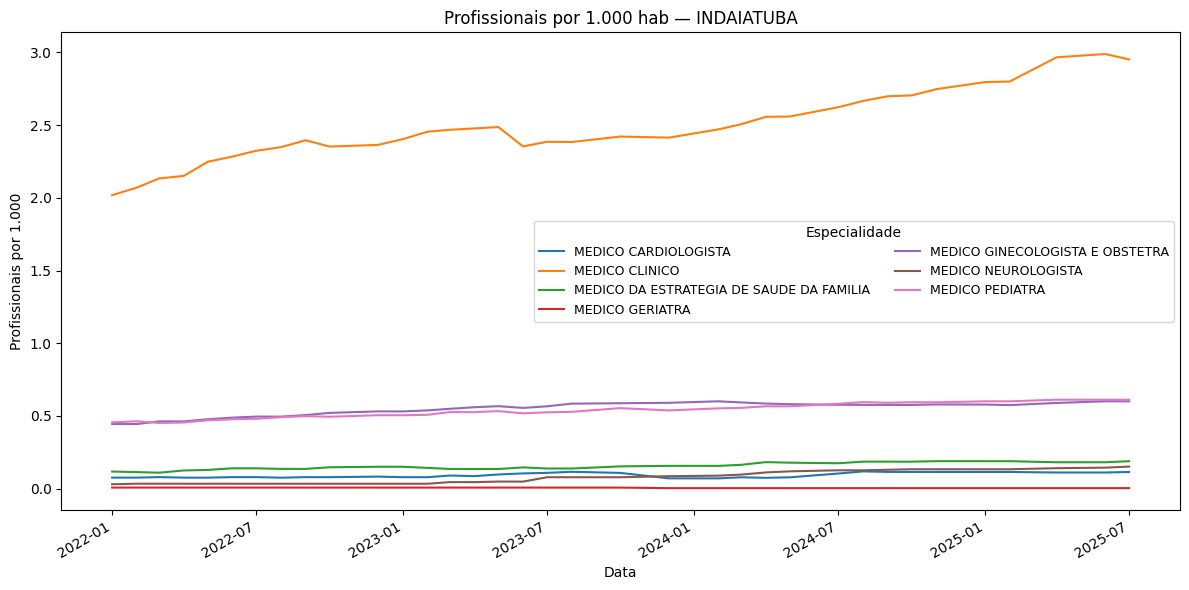

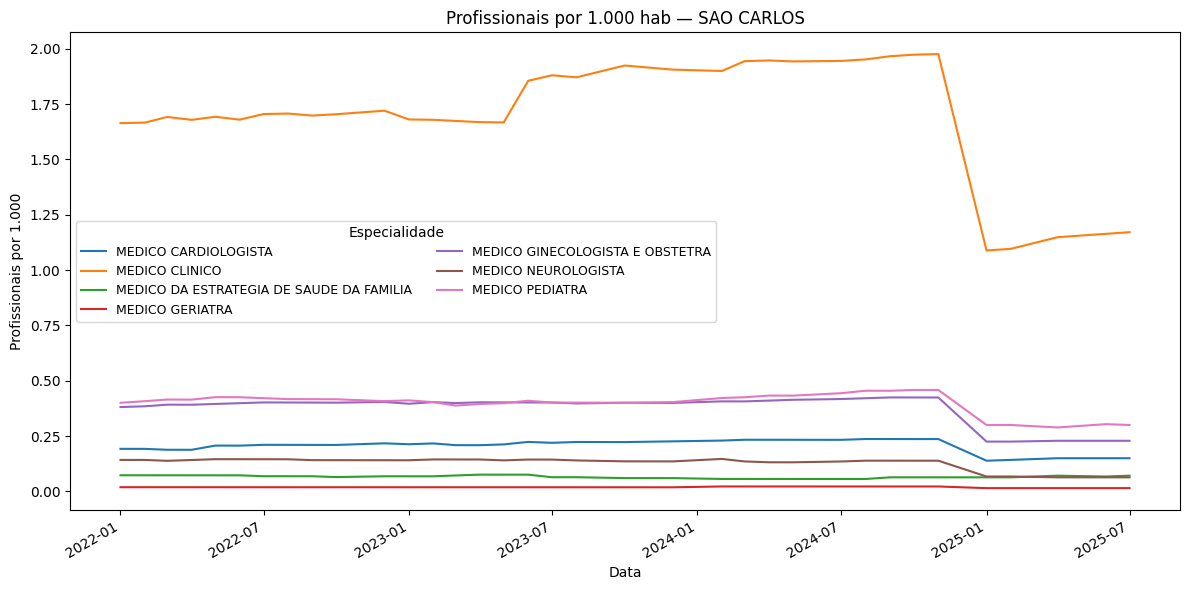

In [169]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_prof_per_1k_over_time(df_final: pd.DataFrame, city: str):
    # cria coluna de data
    df = df_final.copy()
    df["date"] = pd.to_datetime(df["YYYY"].astype(str) + "-" + df["MM"].astype(str).str.zfill(2) + "-01")

    # filtra cidade
    df = df[df["NO_MUNICIPIO"].str.upper().str.strip() == city.upper().strip()]
    if df.empty:
        print(f"Sem dados para {city}.")
        return

    # pivot: linhas = data, colunas = especialidade, valores = profissionais por 1000
    pivot = (
        df.pivot_table(
            index="date",
            columns="DS_ATIVIDADE_PROFISSIONAL",
            values="PROFISSIONAIS_POR_1000",
            aggfunc="mean"
        )
        .sort_index()
    )

    # plota
    ax = pivot.plot(figsize=(12, 6))
    ax.set_title(f"Profissionais por 1.000 hab — {city.upper()}")
    ax.set_xlabel("Data")
    ax.set_ylabel("Profissionais por 1.000")
    ax.legend(title="Especialidade", ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

# uso:
plot_prof_per_1k_over_time(df_final, city="Indaiatuba")
plot_prof_per_1k_over_time(df_final, city="Sao Carlos")



# Writing to Gold

In [ ]:
import io, os
import pyarrow as pa, pyarrow.parquet as pq
from azure.storage.filedatalake import DataLakeServiceClient

def adls_client(account_name: str, account_key: str, file_system: str):
    svc = DataLakeServiceClient(
        account_url=f"https://{account_name}.dfs.core.windows.net",
        credential=account_key
    )
    return svc.get_file_system_client(file_system)

def write_estabelecimentos_partitions(
    df, fs, *, year_col="YYYY", month_col="MM", base="estabelecimentos", overwrite=True
):
    years  = df[year_col].astype(int)
    months = df[month_col].astype(int)
    for (y, m), part in df.groupby([years, months]):
        dest_dir  = f"{base}/{y}/{str(m).zfill(2)}"
        dest_path = f"{dest_dir}/data.parquet"
        # ensure dir
        try: fs.get_directory_client(dest_dir).create_directory()
        except Exception: pass
        # parquet in-memory
        sink = io.BytesIO()
        pq.write_table(pa.Table.from_pandas(part, preserve_index=False), sink, compression="snappy")
        sink.seek(0)
        fs.get_file_client(dest_path).upload_data(sink.read(), overwrite=overwrite)


ACCOUNT_NAME = "cnesstorage"
ACCOUNT_KEY  = os.getenv("AZURE_STORAGE_KEY", "/ae47eZuE0NGPopxVHEkxOKsQwtEm3qQM0vBRPBRbB5nAW1zO6FPkEO9gwNQwkqExaVhOyHWgb68+AStIau+Uw==")
FILE_SYSTEM  = "gold"

fs = adls_client(ACCOUNT_NAME, ACCOUNT_KEY, FILE_SYSTEM)
write_estabelecimentos_partitions(
    df=df_final,
    fs=fs,
    year_col="YYYY",
    month_col="MM",
    base="estabelecimentos",  # root folder
    overwrite=True
)

NameError: name 'df_final' is not defined

In [ ]:
import io, os
import pyarrow as pa, pyarrow.parquet as pq
from azure.storage.filedatalake import DataLakeServiceClient
#Not partitoned
def write_dataframe_to_adls(
    df: pd.DataFrame,
    fs,                             # file system client from adls_fs(...)
    dest_path: str,                 # e.g. "myfolder/data.parquet"
    *,
    overwrite: bool = True,
    compression: str = "snappy"
) -> str:
    """
    Writes a single Parquet file (non-partitioned) to ADLS Gen2.
    Returns the ADLS path written.
    """
    # ensure parent directory exists (idempotent)
    dir_path = "/".join(dest_path.split("/")[:-1])
    if dir_path:
        try:
            fs.get_directory_client(dir_path).create_directory()
        except Exception:
            pass

    # serialize to parquet in-memory
    sink = io.BytesIO()
    table = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_table(table, sink, compression=compression)
    sink.seek(0)

    # upload
    file_client = fs.get_file_client(dest_path)
    file_client.upload_data(sink.read(), overwrite=overwrite)
    return dest_path

###### Write populacao
# pop_br = write_dataframe_to_adls(
#     df=df_pop_monthly,
#     fs=fs,
#     dest_path="populacao/populacao_br/data.parquet",  # your target path
#     overwrite=True,
#     compression="snappy"                         # or "gzip", "zstd", "brotli"
# )
# df_pop_sp = df_pop_monthly.query("CO_UF == 35")
# pop_sp = write_dataframe_to_adls(
#     df=df_pop_sp,
#     fs=fs,
#     dest_path="populacao/populacao_sp/data.parquet",  # your target path
#     overwrite=True,
#     compression="snappy"                         # or "gzip", "zstd", "brotli"
# )

## Estabelecimentos
# estab_sp = write_dataframe_to_adls(
#     df=df_estab_adjusted,
#     fs=fs,
#     dest_path="estabelecimentos/estabelecimentos_sp/data.parquet",  # your target path
#     overwrite=True,
#     compression="snappy"                         # or "gzip", "zstd", "brotli"
# )


estab_sp_com_metricas = write_dataframe_to_adls(
    df=df_final,
    fs=fs,
    dest_path="estabelecimentos/estabelecimentos_sp_metricas_test/data.parquet",  # your target path
    overwrite=True,
    compression="snappy"                         # or "gzip", "zstd", "brotli"
)
## PS: Durante o transform esta sendo filtrado pelo estado de SP (35)